This notebook describes the process for generating a 4^6 combinatorial library from a list of verified imagable 20bp sequences. We call each of these 20bp sequences a "barcode". The library is made from a single oligo pool. The original intent was to have 4^5 oligos in the pool, keeping out 1 barcode to be used as a parity bit for error correction. However the recombinations during oligo synthesis and/or cloning resulted in having most if not all possible combinations in the final library.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# I want to make another oligo library only out of the best 24 barcodes
# excluding barcodes that may interfere with dynamic recording
# I used this as static ID barcodes in a recording array which is injected into mouse zygotes.

# import/create the sequences

# barcode sequences from our screening
ver_BCs = pd.read_csv('verified_barcodes_200305.csv')
# need to take out barcodes from dynamic recording arrays A08 and A09
# since this library is going to be used in conjunction with those arrays
ver_BCs_for_recording = ver_BCs.loc[(~ver_BCs['name'].str.contains('A09')) & 
                                    (~ver_BCs['name'].str.contains('A08'))]\
                                    .sort_values('quality', ascending=False, ignore_index=True).iloc[0:24,:]
bc_list = np.asarray(ver_BCs_for_recording.sequence).reshape([4,6])

# sequences used in cloning
spacers = np.array(['AACCT','ACGTC','ACTGC','CTAAC','CATTG','TTGCC','CGATG','CATAC','CCAGT','TCTGT','GTGTC'])
primers = np.array([['CGTAAACGGCCACAAGTTCG','CGCACGACTTCTTCAAGTCC'],['AAGGGCATCGACTTCAAGCG','CGCAGAAGAACGGCATCAAG']])
BpiI_5 = 'GAAGACagATGG'
BpiI_3 = 'CTCCctGTCTTC'

In [5]:
# generate the codes
codes = []

for i in range(4**5):
    base = np.base_repr(i, base=4).zfill(5)
    base_list = list(map(int,(list(base))))
    parity = sum(base_list)%4
    base_list.insert(0,parity)
    codes.append(base_list)
    
codes = np.array(codes)

In [6]:
# create the oligo sequences
oligos = []
for i in range(4**5):
    o = primers[0][0]
    for j in range(6):
        o = o + bc_list[codes[i][j],j] + spacers[j]
    o = o[:-5] + primers[0][1]
    oligos.append(o)

In [12]:
# test them for BsaI, BpiI, Esp3I cut sites, as well as 5bp long homopolymers
BsaI = ['GGTCTC','GAGACC']
BpiI = ['GAAGAC','GTCTTC']
Esp3I = ['GAGACG','CGTCTC']
homopolymer = ['AAAAA','TTTTT','CCCCC','GGGGG']

bsaI_ = []
esp3I_ = []
homo_ = []
bpiI_ = []

for i in range(len(oligos)):
    query = oligos[i].upper()
    bsaI_.append(BsaI[0] in query or BsaI[1] in query)
    esp3I_.append(Esp3I[0] in query or Esp3I[1] in query)
    homo_.append('AAAAA' in query or 'TTTTT' in query or 'CCCCC' in query or 'GGGGG' in query)
    bpiI_.append(BpiI[0] in query or BpiI[1] in query)

df = pd.DataFrame(list(zip(bsaI_, esp3I_, homo_, bpiI_, oligos)), 
               columns =['BsaI', 'Esp3I', 'Homopolymer', 'BpiI', 'Combination']) 


for i in ver_BCs['sequence']:
    col = ver_BCs.loc[ver_BCs['sequence'] == i]['name'].values[0]
    val = []
    for j in range(len(oligos)):
            query = oligos[j].upper()
            val.append(query.count(i.upper()))
    
    df[col] = val
    
print('Does not include any BsaI site: {}'.format(sum(df['BsaI']) == 0))
print('Does not include any Esp3I site: {}'.format(sum(df['Esp3I']) == 0))
print('Does not include any BpiI site: {}'.format(sum(df['BpiI']) == 0))
print('Does not include any homopolyer 5bp or longer: {}'.format(sum(df['Homopolymer']) == 0))

bc_check = []
for i in range(5,53):
    bc_check.append((sum(df.iloc[:,i]) == len(df)/4) or (sum(df.iloc[:,i]) == 0))

print('Each barcode is used in 1/4 of the combinations: {}'.format(sum(bc_check) == 48))

Does not include any BsaI site: True
Does not include any Esp3I site: True
Does not include any BpiI site: True
Does not include any homopolyer 5bp or longer: True
Each barcode is used in 1/4 of the combinations: True


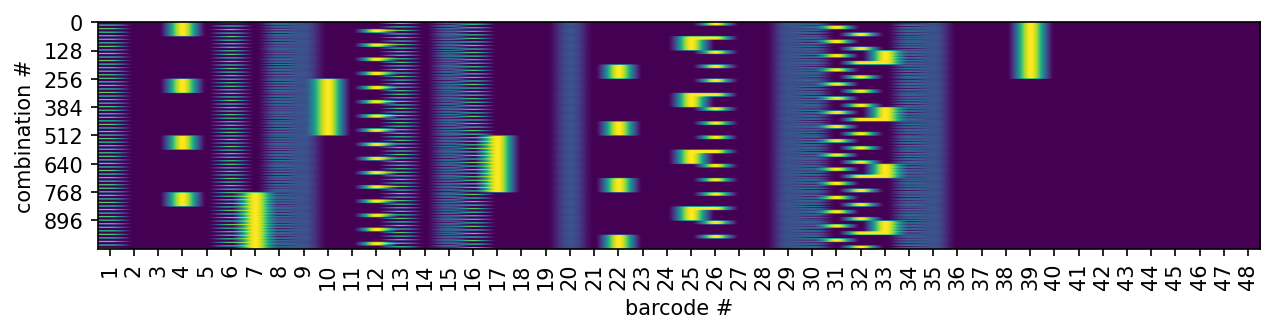

In [14]:
# visualize the oligos to make sure everything is correct
bc_in_oligo = []
for i in ver_BCs['sequence']:
    col = ver_BCs.loc[ver_BCs['sequence'] == i]['name'].values[0]
    val = []
    for j in range(len(oligos)):
            query = oligos[j].upper()
            val.append(query.count(i.upper()))
    bc_in_oligo.append(val)


# visualize the oligos to make sure everything is correct
bc_in_oligo = []
for i in ver_BCs['sequence']:
    col = ver_BCs.loc[ver_BCs['sequence'] == i]['name'].values[0]
    val = []
    for j in range(len(oligos)):
            query = oligos[j].upper()
            val.append(query.count(i.upper()))
    bc_in_oligo.append(val)

# fig = imagesc.seaborn(np.transpose(np.asarray(bc_in_oligo)))
plt.figure(figsize=(10,2), dpi=150)
plt.imshow(np.transpose(np.asarray(bc_in_oligo)), aspect='auto')
plt.yticks(np.arange(0,1024,128))
plt.xticks(np.arange(48), labels=np.arange(1,49,1), rotation='vertical')
plt.xlabel('barcode #')
plt.ylabel('combination #')
plt.show()

In [15]:
# export sequences in Twist format 
name = []
sequence = []

for oligo in range(4**5):
    name.append('lib_4e3_bc' + np.base_repr(oligo, base=4).zfill(5))
    sequence.append(oligos[oligo])
        
T = pd.DataFrame(list(zip(name,sequence)), columns =['name', 'sequence'])
T.to_csv('lib_4e3_oligos.txt', index=False)